<a href="https://colab.research.google.com/github/reddsauce1/FiddleheadsDemo/blob/main/final_first_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**

In this exercise we will explore census data that builds a logistic regression model that predicts income of above or below $50,000.

The data comes from a well known dataset from the reknowned UC Irvine database (https://archive.ics.uci.edu/dataset/2/adult).
The data extraction was done by Barry Becker from the 1994 Census database.

Here is an outline of our objectives for this project:

* Step 1: Data Processing and Model Fitting <br>
Using HMDA data, we will preprocess and fit a logistic regression classification model. The goal is to classify an individual with an income greater than \$50,000 (1) or less than or equal to \$50,000 (0), identifying key features influencing the results.

* Step 2: Model Evaluation Metrics <br>
We will evaluate the model's performance using balanced accuracy instead of default accuracy metrics. Balanced accuracy accounts for dataset imbalances, offering a more equitable measure of predictive ability.

* Step 3: Model Interpretability <br>
Using LIME and SHAP, we will analyze feature importance both globally and locally, gaining insights into which factors most significantly influence the model's predictions.

* Step 4: Fairness Analysis <br>
Leveraging Microsoft Fairlearn, we will assess fairness across demographic groups and explore potential strategies to mitigate disparities.

* Step 5: Data Drift Evaluation <br>
Evidently will be used to analyze data drift, evaluating how well a model trained on one dataset performs on another and diagnosing implications for its predictive accuracy.

# **Step 1: Import Data, Processing and Model Fitting**

This is a bit of a different type of import that we are used to handling. Here we will import directly from the UCI api via it's custom python library.

The data comes separated by features and targets. We will initially concatenate these, perform some pre-processing then re-split into train and test sets as Pandas dataframe objects.

Some highlights of the pre-processing include converting the target variable  from a character type to an integer. If the target is "<=50k" it will be denoted by a 0 and ">50k" will be cast as a 1. Pandas makes this easy to do in a single line of code. It cleverly performs an equivalence across the entire array of the target variable, where is succeeds it will assign a 1 and where it fails it will assign a 0.

Then we will use one-hot encoding to properly handle all the categorical columns and properly map then to a useable numerical format. Again, this is all made easy with Pandas.

Lastly, we will normalize the numerical fields.


## Library Import

In [11]:
!pip install fairlearn
!pip install evidently
!pip install shap
!pip install lime

In [12]:
import pandas as pd

from tabulate import tabulate
import textwrap

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)

import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity


import evidently

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

from IPython import display
from datetime import date

pd.set_option("display.float_format", "{:.2f}".format)
sns.set()

import warnings
warnings.filterwarnings('ignore')

#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

## Data Import <br>



In [37]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']

# Import as pandas DataFrame object
df = pd.read_csv(url, names=column_names, na_values=' ?')
orig_row_count = len(df)

print(f'There are {df.isna().any(axis=1).sum():,} rows out of {orig_row_count:,} that have at least 1 NA value.\n')
print(f'We will drop these rows from the dataset.\n')

df = df.dropna()

print(f'The dataset is now comprised of {len(df):,} records described by {len(df.columns):,} features.\n')

print(f'Below are the first 5 records in the dataset:\n')
df.head()

There are 2,399 rows out of 32,561 that have at least 1 NA value.

We will drop these rows from the dataset.

The dataset is now comprised of 30,162 records described by 15 features.

Below are the first 5 records in the dataset:



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Exploration

We want to build some intuition about the data and get an understanding of how it is distributed. A key consideration is normalizing the numerical data. First, we will look at all the data.

In [38]:
# Function to print variables and range of values for categorical variables
def print_grouped_table(df, wrap_width=40):
    summary = []
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            var_type = "Numeric"
            description = f"Range: {df[column].min()} to {df[column].max()}"
        elif pd.api.types.is_object_dtype(df[column]):
            var_type = "Character"
            description = f"Unique Values: {df[column].unique().tolist()}"
        else:
            var_type = "Other"
            description = "N/A"
        # Wrap the description text
        wrapped_description = textwrap.fill(description, width=wrap_width)
        summary.append({'Variable': column, 'Type': var_type, 'Description': wrapped_description})

    # Convert to DataFrame for better formatting
    summary_df = pd.DataFrame(summary)
    summary_df.sort_values(by='Type', inplace=True)  # Group by type

    # Display as a table
    print(f"Table of unique values and numerical ranges:\n{tabulate(summary_df, headers='keys', tablefmt='grid', showindex=False)}")

# Print the grouped table
print_grouped_table(df, wrap_width=90)


# Export Data to CSV (Optional)
#from google.colab import drive
#drive.mount('/content/drive')
#df.to_csv('/content/drive/My Drive/Colab Notebooks/uci_income_data.csv', index=False)

Table of unique values and numerical ranges:
+----------------+-----------+--------------------------------------------------------------------------------------------+
| Variable       | Type      | Description                                                                                |
+================+===========+============================================================================================+
| workclass      | Character | Unique Values: [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-    |
|                |           | gov', ' Self-emp-inc', ' Without-pay']                                                     |
+----------------+-----------+--------------------------------------------------------------------------------------------+
| education      | Character | Unique Values: [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college', '  |
|                |           | Assoc-acdm', ' 7th-8th', ' Doctorate', ' Assoc-voc', ' P

There are 8 categorical features, 6 numerical features and 1 target variable.

## Plots
Let's now look at the distributions of important categorical features like race, sex, education, and workclass to check for imbalances.

Because we are interested in interrogating our model for bias and fairness we need to get an idea of any imbalances in the data distribution itself so we can address any imbalances.

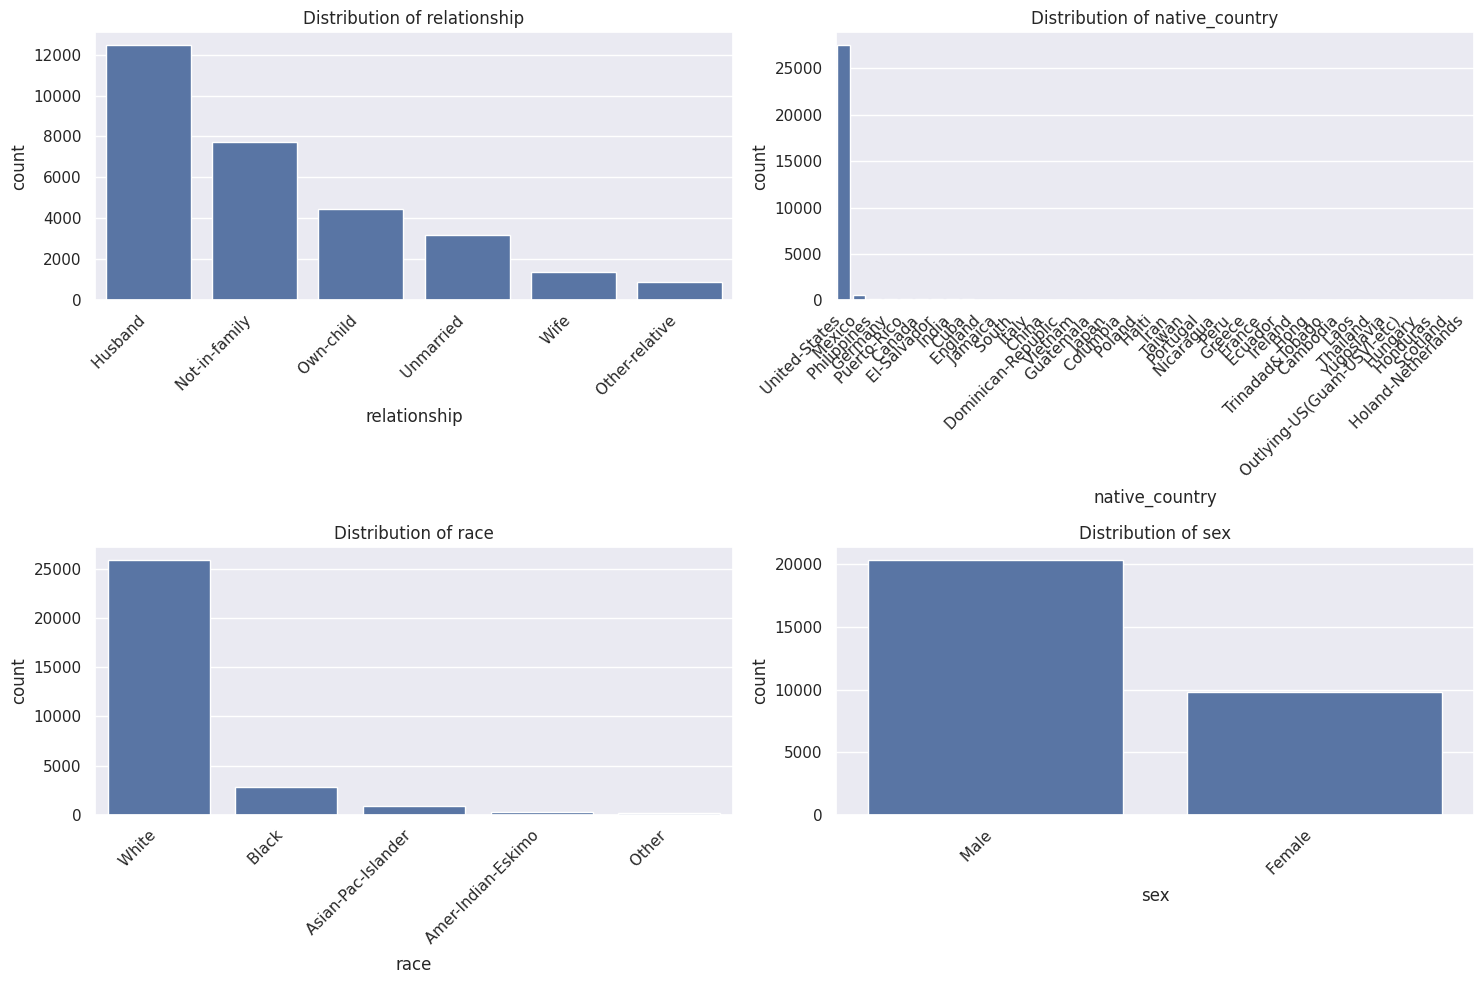

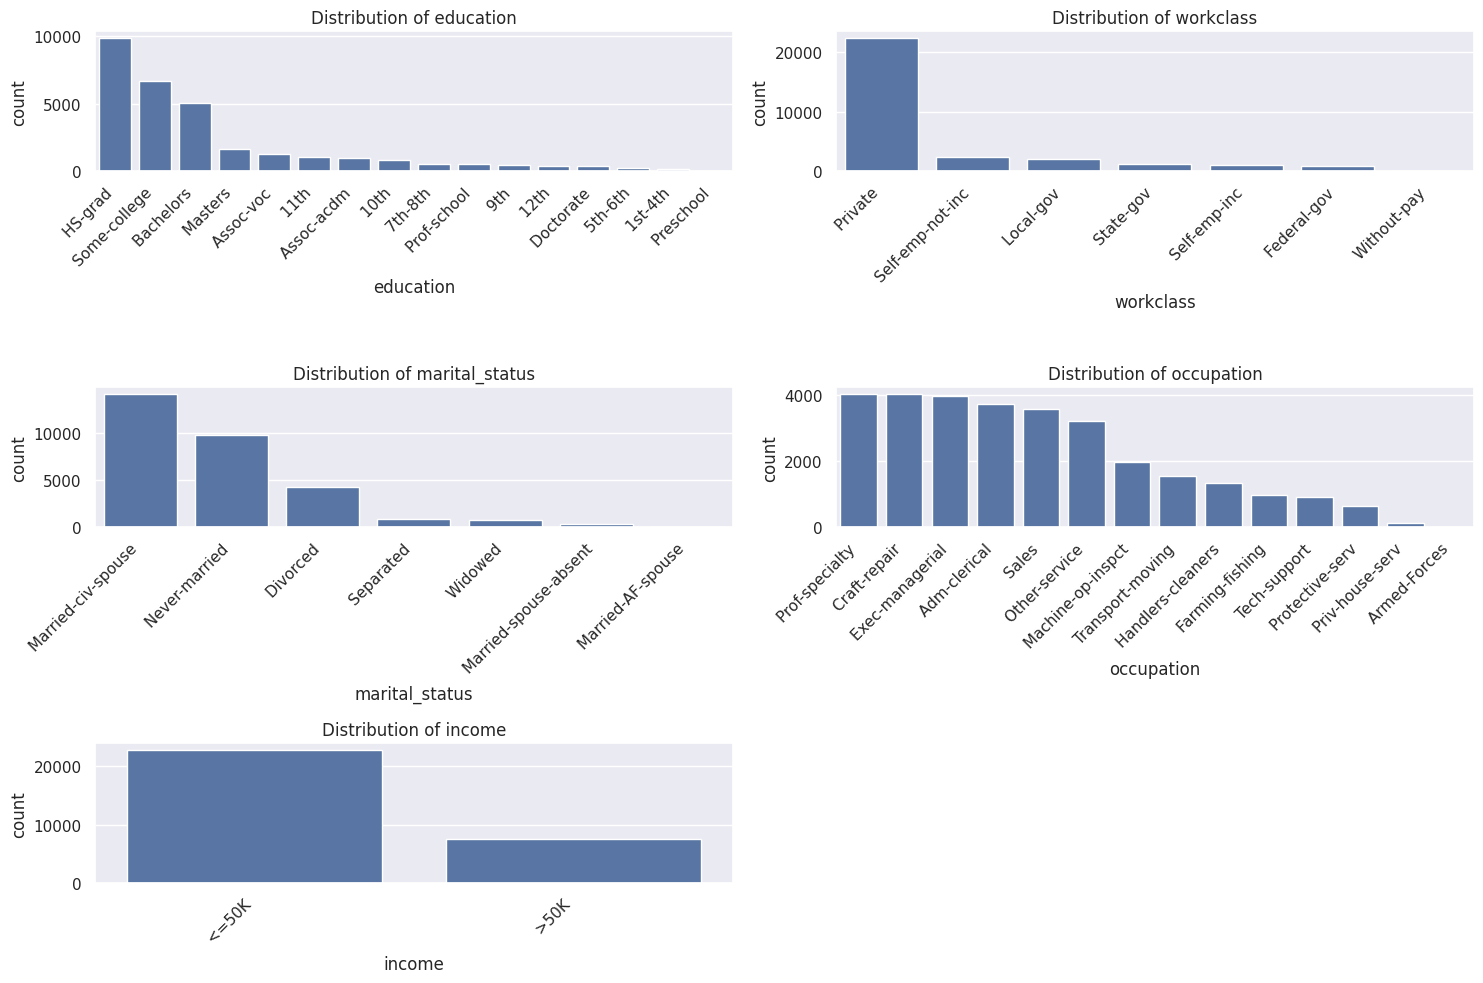

In [39]:
# Categorical feature distributions
categorical_columns = ['relationship', 'native_country', 'race', 'sex', 'education', 'workclass', 'marital_status', 'occupation', 'income']

# Create subplots in a 2x2 layout for the first set of plots
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i, col in enumerate(categorical_columns[:len(axes)]):  # Only plot the first set
    #print(f"\nDistribution of {col}:\n")
    #print(df[col].value_counts(normalize=True) * 100)
    ax = axes[i]
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout for the first set
plt.tight_layout()
plt.show()

# Handle any remaining columns
remaining_columns = categorical_columns[len(axes):]
if remaining_columns:
    # Determine the number of rows and columns for the second set of plots
    num_plots = len(remaining_columns)
    rows = (num_plots + cols - 1) // cols  # Ensure enough rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(remaining_columns):
        #print(f"\nDistribution of {col}:\n")
        #print(df[col].value_counts(normalize=True) * 100)
        if i >= len(axes):  # Avoid accessing out-of-bounds index
            break
        ax = axes[i]
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove any unused subplot axes
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for the second set
    plt.tight_layout()
    plt.show()

The main takeaway from the distributions is that each categorical variable is heavily skewed to the right. This includes our target variable. We will address this later when we employ balancing techniques to flatten the data.<br><br>
Let’s now explore relationships between key features (like age, hours per week, and education_num) and the target variable (income) to see how they interact.

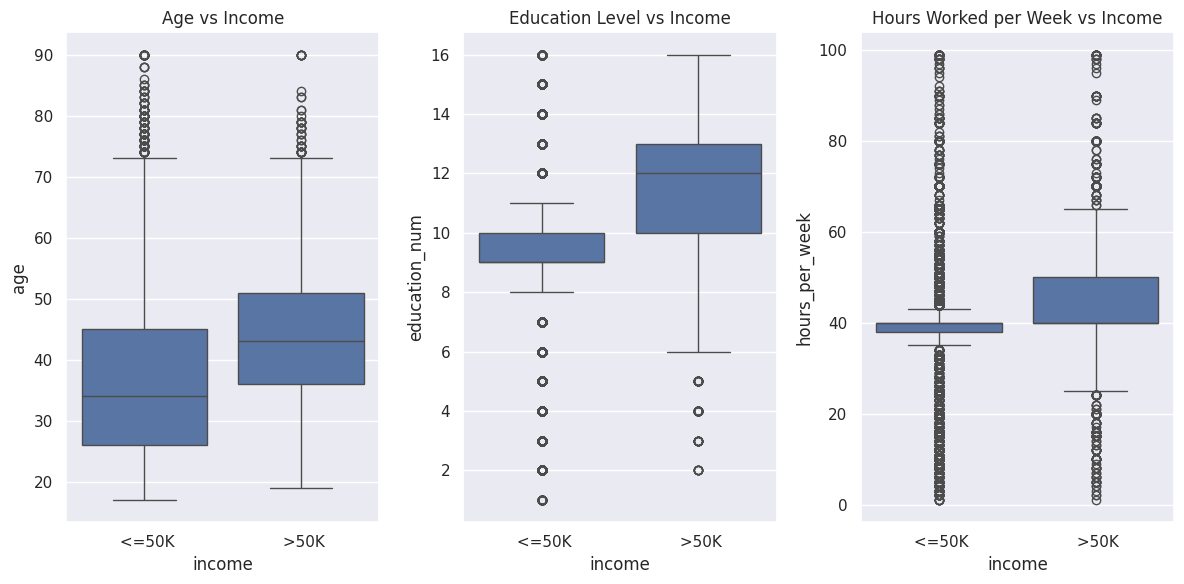

In [40]:
# Plotting age, education_num, and hours_per_week vs income
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=df, x='income', y='age', ax=ax[0])
ax[0].set_title('Age vs Income')

sns.boxplot(data=df, x='income', y='education_num', ax=ax[1])
ax[1].set_title('Education Level vs Income')

sns.boxplot(data=df, x='income', y='hours_per_week', ax=ax[2])
ax[2].set_title('Hours Worked per Week vs Income')

plt.tight_layout()
plt.show()

These box plots reveal key insights about the relationship between numerical features and income levels:
	1.	Age: Higher income (>50K) correlates with older age, but the significant overlap between groups suggests age alone is not a strong predictor.
	2.	Education Level: Higher education_num strongly correlates with >50K income, with the >50K group having a noticeably higher median and broader distribution.
	3.	Hours Worked: The >50K group generally works more hours per week, but the high variability indicates hours worked is not a definitive predictor of income.

Lastly, we’ll create a correlation heatmap to understand how the numerical features are correlated with one another. High correlations might indicate multicollinearity (where features are highly related), which we need to account for in modeling.
<br><br>
Heatmaps are an important tool for helping identify features that move together. If certain variables are highly correlated it could result in a model that over represents a feature of the data. It's important to build a model that is predictive but also lean. The heatmaps will provide some insight into this potential issue.

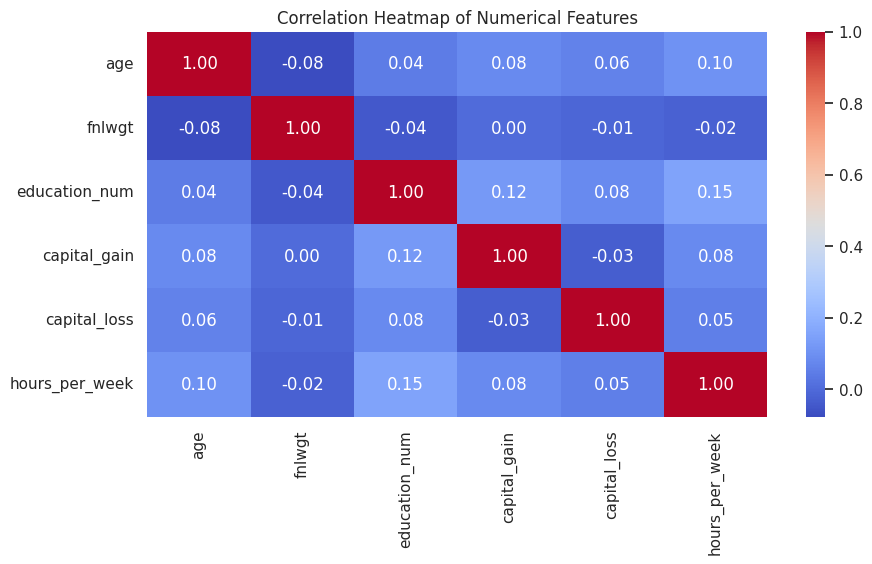

In [41]:
# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Display the correlation heatmap, including income
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

None of the numerical values are showing a correlation to each other. This is good but will be computationally more expensive the larger our input is.

## Data Transformations

In this section we will use what we have learned to try to adjust and transform the data so that it is optimally formatted for the logistic regression model.



### **Dropping**

Some variables are irrelevant due to sparsity or redundancy. For example, the education feature is categorical but has a numerical equivalent in education_num. Since education_num provides the same information in a simpler format, we can drop the education feature to streamline the model.

In [42]:
df.drop(columns=['education', 'fnlwgt'], inplace=True)

### **Bucketing**

Some of the categorical variables have a wide range of possible values. If we one-hot encode this it will add a lot of dimensionality to the model. This could be computationally expensive and also added unnecessary complexity. To address this we will shrink the size of the domain of 'native_country', '

In [45]:
df['native_country'] = df['native_country'].apply(lambda x: 'US' if x == 'United-States' else 'Non-US')
df['workclass'] = df['workclass'].apply(lambda x: 'Private' if x == 'Private' else 'Non-Private')

# Convert 'capital_gain' and 'capital_loss' to boolean (True/False) based on whether they are greater than 0
df['capital_gain'] = df['capital_gain'] > 0
df['capital_loss'] = df['capital_loss'] > 0

# Define the boundaries for the education buckets
bins = [0, 8, 10, 13, 16]
labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Create the 'education_bucket' column
df['education_bucket'] = pd.cut(df['education_num'], bins=bins, labels=labels, right=False)

print(df[['education_num', 'education_bucket']].head(20))

    education_num education_bucket
0              13             High
1              13             High
2               9       Medium-Low
3               7              Low
4              13             High
5              14             High
6               5              Low
7               9       Medium-Low
8              14             High
9              13             High
10             10      Medium-High
11             13             High
12             13             High
13             12      Medium-High
15              4              Low
16              9       Medium-Low
17              9       Medium-Low
18              7              Low
19             14             High
20             16              NaN


### **One-hot Encoding**

One-hot encoding transforms categorical variables into a binary matrix of 0s and 1s, where each column represents a category. This ensures that the machine learning model can process the categorical information effectively.

In [46]:
# re-assign this without 'education' since we removed it above. then add in capital_gain and capital_loss and education_bucket
categorical_columns = ['relationship',
                       'native_country',
                       'race',
                       'sex',
                       'workclass',
                       'marital_status',
                       'occupation',
                       'income',
                       'capital_gain',
                       'capital_loss',
                       'education_bucket']

# Perform one-hot encoding for all categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Check the column names to ensure 'income' is properly encoded
from pprint import pprint
pprint(df_encoded.columns)

Index(['age', 'education_num', 'hours_per_week', 'relationship_ Not-in-family',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Unmarried', 'relationship_ Wife',
       'race_ Asian-Pac-Islander', 'race_ Black', 'race_ Other', 'race_ White',
       'sex_ Male', 'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'income_ >50K', 'capital_gain_

## Normalize Numerical Values

Now that we are finished examining the data visually, we can begin to make some choices about data transformations.

Our goal is to build a logistic regression model which is known to be sensitive to the scale of the input data. Therefore we will normalize the numerical fields.

In [48]:
# Numerical features to normalize
numerical_features = ['age', 'hours_per_week']

# Min-Max Normalization
scaler = MinMaxScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

## Build Train and Test Sets

In [49]:
# Separate features (X) and target (y)
X = df_encoded.drop(columns=['income_ >50K'])  # Features (drop the encoded income column)
y = df_encoded['income_ >50K']  # Target (income)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Check the shape of the resulting datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (24129, 37)
Testing features shape: (6033, 37)
Training labels shape: (24129,)
Testing labels shape: (6033,)


In [50]:
# Balance the training dataset
def resample_dataset(X, y):
    positive_ids = y[y == 1].index
    negative_ids = y[y == 0].index
    balanced_ids = positive_ids.union(np.random.choice(negative_ids, len(positive_ids)))
    return X.loc[balanced_ids], y.loc[balanced_ids]

X_train_bal, y_train_bal = resample_dataset(X_train, y_train)



In [51]:
# Train Logistic Regression Model
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train_bal, y_train_bal)

# Predictions and Metrics
y_pred = pipeline.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.806165603957469


# **Step 2: Model Evaluation Metrics**

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix and transpose it
cm = confusion_matrix(y_test, y_pred)

















# Display the confusion matrix with transposed axes
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# **Step 3: Model Interpretability**

# **Step 4: Fairness Analysis**

# **Step 5: Data Drift Evaluation**

In [ ]:
# Fairness Analysis
from fairlearn.metrics import MetricFrame, false_negative_rate, true_positive_rate

metrics = {
    "False Negative Rate": false_negative_rate,
    "True Positive Rate": true_positive_rate
}
fairness_metrics = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=X_test[sensitive_features[0]])

print(fairness_metrics.by_group)

In [ ]:
# Visualizations
sns.countplot(x=y_train_bal)
plt.title("Balanced Training Dataset Distribution")
plt.show()